### Parsing the log files saved from the execution of GPT models

In [ ]:
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
import json
import re
import os
import sys
sys.path.append("../")

In [3]:
from utils import get_correct_anno
from ner_prompting import gpt_responce, calc_results

False


/Users/z003yzhj/Desktop/Projects/TabNER/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from utils import parse_entities, parse_output

In [5]:
labels_dict = {  
            'Activity': 1,
            'Organisation': 2,
            'ArchitecturalStructure': 3,
            'Event': 4,
            'Place': 5,
            'Person': 6,
            'Work': 7,
                }
labels_dict_rev={v:k for k,v in labels_dict.items()}
print(labels_dict_rev)

{1: 'Activity', 2: 'Organisation', 3: 'ArchitecturalStructure', 4: 'Event', 5: 'Place', 6: 'Person', 7: 'Work'}


In [6]:
data_path="../data/final_NER_labeled_dataset.csv"
with open(data_path, 'r') as f:
    ner_tables = json.load(f)    

### Load log files for the model and extract the entities

Different files require different parsing: somewhere is a string, somewhere is a incomplete dictionary

In [30]:
with open("../output/logs/log_file_gpt-35-turbo-instruct_0_bar.txt") as f:
    output = f.read()

In [34]:
def parse_output(model_name, shot):    
    
    file_name = 'log_file_{}_{}.txt'.format(model_name, shot)   
    with open(os.path.join('../output/logs/', file_name), 'r') as file:
        output = file.read()
        
    # first load the parsed output into dict
    dict_output ={}
    for line in output.split('\n'):
        
        if len(line)>1 and line[0].isdigit():
            current_key = line.split(":")[0]    
            current_value = []
        elif current_key is not None and len(line)>1 and line[0].isdigit() == False:       
            current_value.append(line.replace("'",""))
        dict_output[current_key.rstrip(':')] = current_value
        
    # here clean the values to be in json format, discard not complete lines
    new_dict = {}
    for key, val in dict_output.items():
        new_val = []
        for entity in val:
            new_entity = entity.strip("/', /,")
            try:
                new_val.append(json.loads(new_entity))
            except:
                continue
        new_dict[key] = new_val 
        
   # with open("../output/cleaned/log_file_{}_{}.json".format(model_name, shot), "w") as f:
   #     json.dump(new_dict, f)
    
    return new_dict

In [35]:
output_gpt4 = parse_output("gpt-4", 0)

In [68]:
types = []
for key, val in output_gpt4.items():
    for ent in val:
        types.append(ent["type"])

In [69]:
len(set(types))

10

In [70]:
set(types)

{'Activity',
 'ArchitecturalStructure',
 'Event',
 'Genre',
 'Job',
 'MISC',
 'Organisation',
 'Person',
 'Place',
 'Work'}

In [32]:
common_keys = []
for key in output_gpt4.keys():
    if key in output_gpt35.keys():
        common_keys.append(key)

In [20]:
common_gpt4 = {k:v for k, v in output_gpt4.items() if k in common_keys}

In [21]:
output_gpt35 = {k:v for k, v in output_gpt35.items() if k in common_keys}

In [22]:
len(output_gpt35) == len(common_gpt4)

True

In [23]:
def get_labels(test): 
    dict_results = {}
    dict_results["true_label"] = []
    dict_results["predicted_label"] = []
    dict_results["incorrect_span_predict"] = []
    dict_results["incorrect_span_gt"] = []
    dict_results["incorrect_cell_predict"] = []
    dict_results["incorrect_cell_gt"] = []
    total_preds = 0
    total_correct = 0
    for key, value in test.items():    
        for idx in range(len(ner_tables)):    

            ser_correct_annot = []        
            table = ner_tables[idx][0]
            tab_id = table[0]

            if tab_id == key:
                
                
                tab_csv, outs, tab_matrix = get_correct_anno(ner_tables[idx][0], labels_dict_rev) 
                predicted = gpt_responce(tab_matrix, test[key], labels_dict)

                row_labels = table[6]
                for i in range(len(row_labels)):
                    ser_correct_annot.append([el for el in row_labels[i][0]])

                ser_gt = [tuple(item) for sublist in ser_correct_annot for item in sublist]
                total_correct += len(ser_gt)
                
                if len(predicted[0]) == 0:
                    continue
                
                for i in range(len(predicted)):
                    total_preds += len(predicted[i])
                    for el in predicted[i]:      
                        for tup in ser_gt:
                            
                            if el[0:4] == tup[0:4] and el[4]!=tup[4]:
                                dict_results["true_label"].append(tup[4])
                                dict_results["predicted_label"].append(el[4])                                
                            
                            # for span - check if cell index and label are the same
                            elif ((el[0:3] == tup[0:3] and el[3]!=tup[3] and el[4]==tup[4])
                                or (el[0:2] == tup[0:2] and el[2]!=tup[2] and el[3:]==tup[3:])):
                                dict_results["incorrect_span_predict"].append(el)
                                dict_results["incorrect_span_gt"].append(tup)
                                
                            # for cell - check if only the column index is different
                            elif ((el[0]==tup[0] and el[1] != tup[1] and el[2:]==tup[2:])
                                  or (el[0]!=tup[0] and el[1:]==tup[1:])):
                                dict_results["incorrect_cell_predict"].append(el)
                                dict_results["incorrect_cell_gt"].append(tup)                               
  
                            
    return dict_results, total_preds, total_correct

In [ ]:
dict_results, total, total_correct = get_labels(output_gpt35)

In [25]:
for key, val in dict_results.items():
    if key == ("predicted_label" or "true_label"):
        print(key, len(val), len(val)/total)
    else:
        print(key, len(set(val)), len(set(val))/total)

true_label 8 0.0011632979496873637
predicted_label 1855 0.26973971208375747
incorrect_span_predict 183 0.026610440599098444
incorrect_span_gt 235 0.03417187727206631
incorrect_cell_predict 749 0.10891377053947943
incorrect_cell_gt 841 0.1222916969608841


In [ ]:
dict_results, total, total_correct = get_labels(common_gpt4)

In [28]:
for key, val in dict_results.items():
    if key == ("predicted_label" or "true_label"):
        print(key, len(val), len(val)/total)
    else:
        print(key, len(set(val)), len(set(val))/total)

true_label 8 0.0007589412769186984
predicted_label 2553 0.24219713499667964
incorrect_span_predict 529 0.05018499193624893
incorrect_span_gt 723 0.06858931790152736
incorrect_cell_predict 878 0.08329380514182715
incorrect_cell_gt 918 0.08708851152642064


In [185]:
dict_results, total, total_correct = get_labels(common_gpt4)

In [186]:
total, total_correct

(1245, 1502)

In [187]:
for key, val in dict_results.items():
    if key == ("predicted_label" or "true_label"):
        print(key, len(val), len(val)/total)
    else:
        print(key, len(set(val)), len(set(val))/total)

true_label 3 0.0024096385542168677
predicted_label 268 0.21526104417670683
incorrect_span_predict 49 0.0393574297188755
incorrect_span_gt 49 0.0393574297188755
incorrect_cell_predict 239 0.19196787148594377
incorrect_cell_gt 270 0.21686746987951808


In [188]:
dict_results_inst, total, total_correct = get_labels(common_gpt_instruct)

In [191]:
for key, val in dict_results_inst.items():
    if key == ("predicted_label" or "true_label"):
        print(key, len(val), len(val)/total)
    else:
        print(key, len(set(val)), len(set(val))/total)

true_label 1 0.003246753246753247
predicted_label 80 0.2597402597402597
incorrect_span_predict 0 0.0
incorrect_span_gt 0 0.0
incorrect_cell_predict 62 0.2012987012987013
incorrect_cell_gt 91 0.29545454545454547


### Plot conf matrix

In [40]:
labels_dict_rev

{1: 'Activity',
 2: 'Organisation',
 3: 'ArchitecturalStructure',
 4: 'Event',
 5: 'Place',
 6: 'Person',
 7: 'Work'}

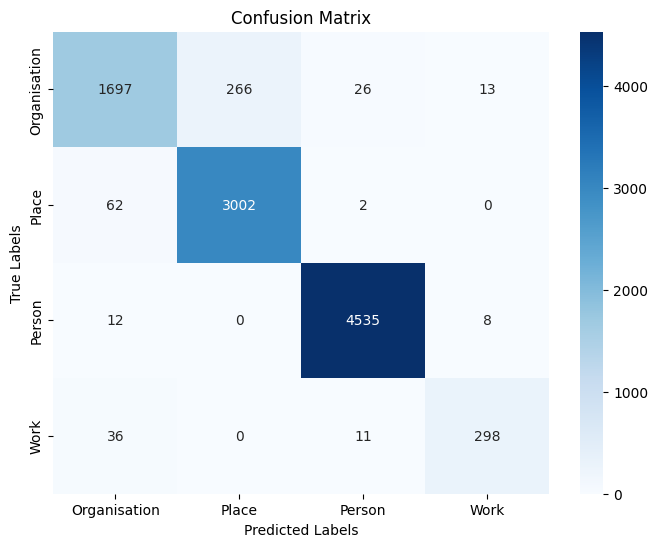

In [55]:
cm_3 = confusion_matrix(true, predict)
#print(cm)
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt="d", cmap="Blues", xticklabels=labels_dict_rev.values(), yticklabels=labels_dict_rev.values())
plt.xticks(rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.show()

plt.savefig("../output/plots/cm_gpt-35-turbo-16k_3_bar_False_final.png")
